
This python notebook...
* jhg

In [20]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
from scipy import optimize

[     0.   1260.   2520.   3780.   5040.   6300.   7560.   8820.  10080.
  11340.  12600.  13860.  15120.  16380.  17640.  18900.  20160.  21420.
  22680.  23940.  25200.  26460.  27720.  28980.  30240.  31500.  32760.
  34020.  35280.  36540.  37800.  39060.  40320.  41580.  42840.  44100.
  45360.  46620.  47880.  49140.  50400.  51660.  52920.  54180.  55440.
  56700.  57960.  59220.  60480.  61740.  63000.  64260.  65520.  66780.
  68040.  69300.  70560.  71820.  73080.  74340.  75600.  76860.  78120.
  79380.  80640.  81900.  83160.]


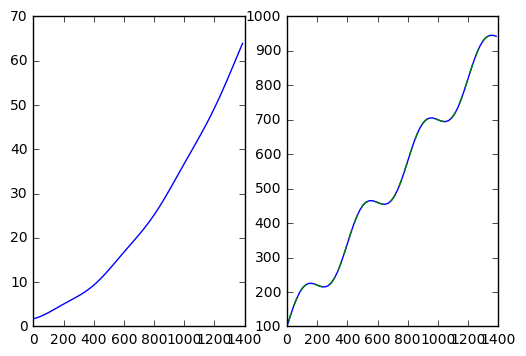

In [21]:
rsun = 6.957e8
h_model = lambda t, *a: -a[0]*np.cos((2*np.pi*t)/a[1] + a[2])/(2*np.pi/a[1]) + a[3]*t + 0.5*a[4]*t**2 + a[5]
v_model = lambda t, *a: a[0]*np.sin(2*np.pi*t/a[1] +a[2]) + a[3] + a[4] * t

orig_parms = np.array([50*1e3, 400*60, 0, 100*1e3, 10, 2*rsun]) #amp, freq, phase, velocity, acc

t = np.arange(0.0, 1400*60, 21*60)
h = h_model(t, *orig_parms)
v = v_model(t, *orig_parms[:-1])

t_diff = t[:-1]+(t[1:]-t[0:-1])*0.5
v_diff = np.diff(h)/np.diff(t)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(t/60, h/rsun)
ax2.plot(t/60, v/1e3)
ax2.plot(t_diff/60, v_diff/1000, '--')
print (t)

C:\Users\Betsy\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[  1.59041158e+05   5.61417872e+05   7.50760697e+04  -1.18577283e+05
   4.39380350e-01   1.39140000e+09]


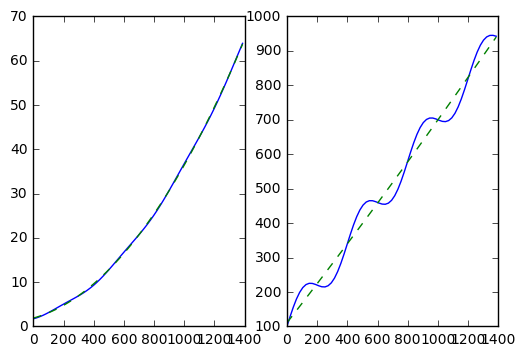

In [22]:
popt, pcov = optimize.curve_fit(h_model, t, h, p0=np.ones(6))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(t/60, h/rsun)
ax1.plot(t/60, h_model(t, *popt)/rsun, '--')
ax2.plot(t/60, v/1e3)
ax2.plot(t/60, v_model(t, *popt[:-1])/1e3, '--')

print(orig_parms-popt)

So we can see the fit has sucseeded but given a terrible fit resutl, the parameters are way off, like order of magnitude out.

So cearly the fit is finding a local minimum and not the global one two things to check are:
* the initial guess (defaults to 1 for all parameters)
* fit limits

For the initial guess we just need to do better than the default

[  6.49843194e+04   2.16536911e+04   4.06540477e+01  -8.11877771e+02
   1.54062480e-02   1.77684692e+07]


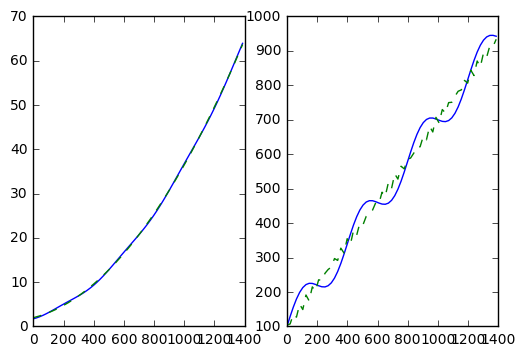

In [28]:
#Set inital geuss to order of magntide ie 50*1e3 ~ 1e4
popt, pcov = optimize.curve_fit(h_model, t, h, p0=[1e4, 1e4, 0, 1e5, 10, 1e9]) 

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(t/60, h/rsun)
ax1.plot(t/60, h_model(t, *popt)/rsun, '--')
ax2.plot(t/60, v/1e3)
ax2.plot(t/60, v_model(t, *popt[:-1])/1e3, '--')

print(orig_parms-popt)

So we can see an improvement but it still no great so lets see if we give it the actual paramter does the work.

[ -1.45909726e-04   1.06605417e-04   6.41671284e-08   1.38965042e-04
  -2.00207317e-09  -3.71256924e+00]


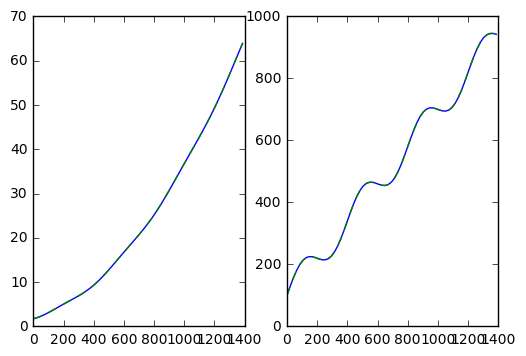

In [24]:
#Set inital geuss to actual values used
popt, pcov = optimize.curve_fit(h_model, t, h, p0=orig_parms*1.1) 

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(t/60, h/rsun)
ax1.plot(t/60, h_model(t, *popt)/rsun, '--')
ax2.plot(t/60, v/1e3)
ax2.plot(t/60, v_model(t, *popt[:-1])/1e3, '--')

print(orig_parms-popt)

So we can see it works as expected but in the real anaylsis we won't know the values so let look at the constraints.

[  5.00000000e+04   1.20054910e+04  -2.81326767e+00  -8.76451618e+02
   1.65719194e-02   1.92445001e+07]


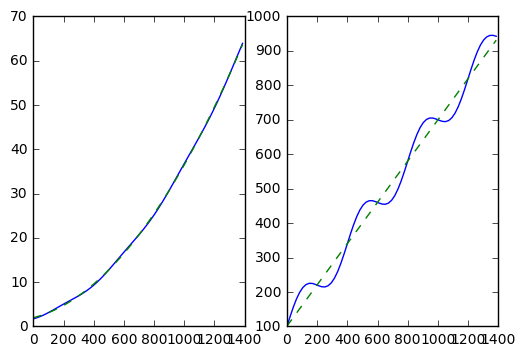

In [25]:
# Set inital geuss to order of magntide ie 50*1e3 ~ 1e4
# Simplist limits all the parms should be positive
limits=(np.zeros(6), np.full([6], np.inf))
popt, pcov = optimize.curve_fit(h_model, t, h, [1e4, 1e4, 0, 1e5, 10, 1e9], bounds=limits) 

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(t/60, h/rsun)
ax1.plot(t/60, h_model(t, *popt)/rsun, '--')
ax2.plot(t/60, v/1e3)
ax2.plot(t/60, v_model(t, *popt[:-1])/1e3, '--')

print(orig_parms-popt)

Still not giving us a good fit so add some more realistic constraints:
* initial heigth has to be > 1Rsun
* initial velcotity between 0 - 4000km/s
* periods between 20-1000 min
* phase 0-2pi
* accelaeito -50-50 m/s

[  4.16149926e+04   9.39668382e+03  -9.02601005e-18  -1.14127522e+03
   2.33130569e-02   2.33305848e+07]


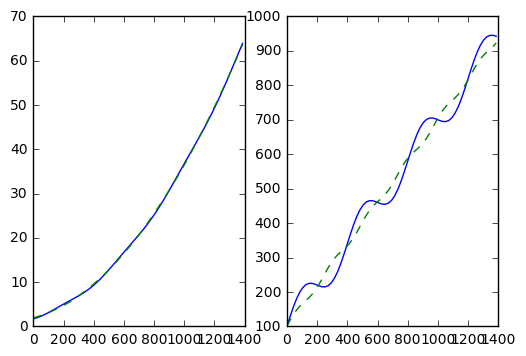

In [26]:
# Set inital geuss to order of magntide ie 50*1e3 ~ 1e4
# More realistic limits limits all the parms should be positive
limits=([1000, 200*60, 0, 1000, -50, 1*rsun], [10*1e4, 800*60, 2*np.pi, 4000*1e3, 50, np.inf])
popt, pcov = optimize.curve_fit(h_model, t, h, p0=[1e4, 300*60, 0, 1e5, 10, 1e9], bounds=limits) 

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(t/60, h/rsun)
ax1.plot(t/60, h_model(t, *popt)/rsun, '--')
ax2.plot(t/60, v/1e3)
ax2.plot(t/60, v_model(t, *popt[:-1])/1e3, '--')

#print(orig_parms, '\n', popt)
print(orig_parms-popt)

What I found interesting is that most of the parameters are good the only ones that are off are the ampliturde a0 and the period a1. Also if  you look at all the runs above the frequeney is always to low so what if we start it higher than the actual frequencey.

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[ -5.88269249e-05   8.58206331e-05   4.59879260e-08   7.67698803e-05
  -7.96616106e-10  -2.46616507e+00]
[  3.27309834e-04  -3.37184403e-04  -2.05301192e-07   4.22885336e-04
  -7.81610687e-09]


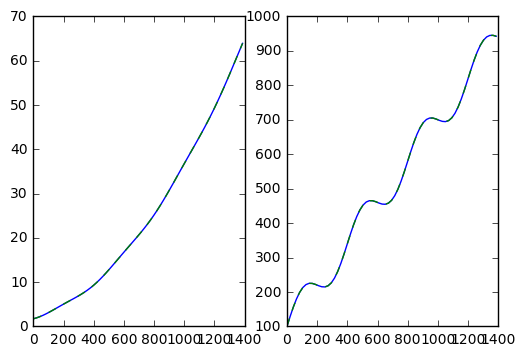

In [68]:
limits=(np.zeros(5), np.full([5], np.inf))

#original limits for this cell
#limits=([10*1e3, 100*60, 0, 1000, -20, 1*rsun], [1000*1e3, 1400*60, 2*np.pi, 3500*1e3, 20, 10*rsun])

limits=([10*1e3, 100*60, 0, 1000, -20, 1*rsun], [10*1e4, 800*60, 2*np.pi, 3500*1e3, 20, 10*rsun])
hopt, hcov = optimize.curve_fit(h_model, t, h, p0=[50*1e3, 1000*60, 0, 1e5, 10, 1*rsun])#, bounds=limits)

#in meters
limits=([30*1e3, 1, 0, 0, -20], [200*1e3, 500*60, 2*np.pi, 3500*1e3, 30])
vopt, vcov = optimize.curve_fit(v_model, t, v, p0=[50*1e3, 500*60, 0, 1e5, 10], bounds=limits)
print (type(t))
print (type(v))

#print(orig_parms)
#print(hopt)
#print(vopt)
print(orig_parms-hopt)
print(orig_parms[0:5]-vopt)

Fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(t/60, h/rsun)
ax1.plot(t/60, h_model(t, *hopt)/rsun, '--')
ax2.plot(t/60, v/1e3)
ax2.plot(t/60, v_model(t, *vopt)/1e3, '--')



Ok so it cleary the starting period parameter above the actual values seems to work.


